In [1]:
from astropy.io import fits
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score,mean_squared_error
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from scipy.stats import randint
from pprint import pprint
df = pd.read_csv('combined.csv',header=1)

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 47 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   objid           200000 non-null  int64  
 1   u               200000 non-null  float64
 2   g               200000 non-null  float64
 3   r               200000 non-null  float64
 4   i               200000 non-null  float64
 5   z               200000 non-null  float64
 6   modelMag_u      200000 non-null  float64
 7   modelMag_g      200000 non-null  float64
 8   modelMag_r      200000 non-null  float64
 9   modelMag_i      200000 non-null  float64
 10  modelMag_z      200000 non-null  float64
 11  nMgyPerCount_u  200000 non-null  float64
 12  nMgyPerCount_g  200000 non-null  float64
 13  nMgyPerCount_r  200000 non-null  float64
 14  nMgyPerCount_i  200000 non-null  float64
 15  nMgyPerCount_z  200000 non-null  float64
 16  petroMag_u      200000 non-null  float64
 17  petroMag_g

In [3]:
df.head()

,objid,u,g,r,i,z,modelMag_u,modelMag_g,modelMag_r,modelMag_i,...,err_g,err_r,err_i,err_z,expAB_r,deVAB_r,expRad_r,deVRad_r,class,redshift
0,1237648705677558405,19.42596,18.40534,17.54040,17.10209,16.80152,19.42596,18.40534,17.54040,17.10209,...,0.011774,0.008512,0.008704,0.022125,0.725152,0.718584,2.038153,4.106713,GALAXY,0.193908
1,1237648705677623407,17.26143,16.11382,15.91448,15.86646,15.86977,17.26143,16.11382,15.91448,15.86646,...,0.003618,0.003725,0.003777,0.006023,0.150031,0.249987,0.050927,0.025140,STAR,0.000208
2,1237648705677688913,18.31802,16.97997,16.44185,16.23855,16.13750,18.31802,16.97997,16.44185,16.23855,...,0.004336,0.004031,0.004100,0.006820,0.752798,0.992956,0.000426,0.003976,STAR,0.000218
3,1237648705677689059,19.24354,17.55958,16.70882,16.27199,15.96455,19.24354,17.55958,16.70882,16.27199,...,0.005917,0.004524,0.004553,0.009827,0.721513,0.738088,1.819643,2.776990,GALAXY,0.056448
4,1237648705677689065,18.16017,16.86312,16.24890,15.89084,15.64687,18.16017,16.86312,16.24890,15.89084,...,0.006092,0.004596,0.004520,0.011545,0.608859,0.588652,4.768722,12.319670,GALAXY,0.056281


In [4]:
df['class_numeric'] = df['class'].replace({'QSO': 0, 'STAR': 1, 'GALAXY': 2})

C:\Users\Shakthi\AppData\Local\Temp\ipykernel_12364\3448048250.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['class_numeric'] = df['class'].replace({'QSO': 0, 'STAR': 1, 'GALAXY': 2})


In [5]:
features = ['u', 'g', 'r', 'i', 'z','class_numeric']
target = 'redshift'
X = df[features]
y = df[target]

In [6]:
param_grid = {
    'n_estimators': [50, 100,200,300,400,500],  # Number of trees
    'bootstrap':[True]
}

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf = RandomForestRegressor()

In [8]:
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True],
                         'n_estimators': [50, 100, 200, 300, 400, 500]},
             scoring='r2', verbose=1)

In [9]:
best_rf = grid_search.best_estimator_
best_rf.fit(X_train, y_train)
train_pred = best_rf.predict(X_train)
test_pred = best_rf.predict(X_test)
train_loss = mean_squared_error(y_train, train_pred)
test_loss = mean_squared_error(y_test, test_pred)

In [10]:
test_loss

0.027612271642411316

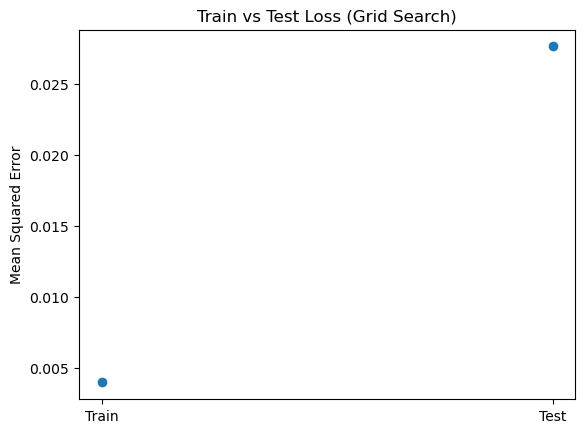

In [17]:
plt.scatter(['Train', 'Test'], [train_loss, test_loss], marker='o', linestyle='-')
plt.ylabel("Mean Squared Error")
plt.title("Train vs Test Loss (Grid Search)")
plt.show()

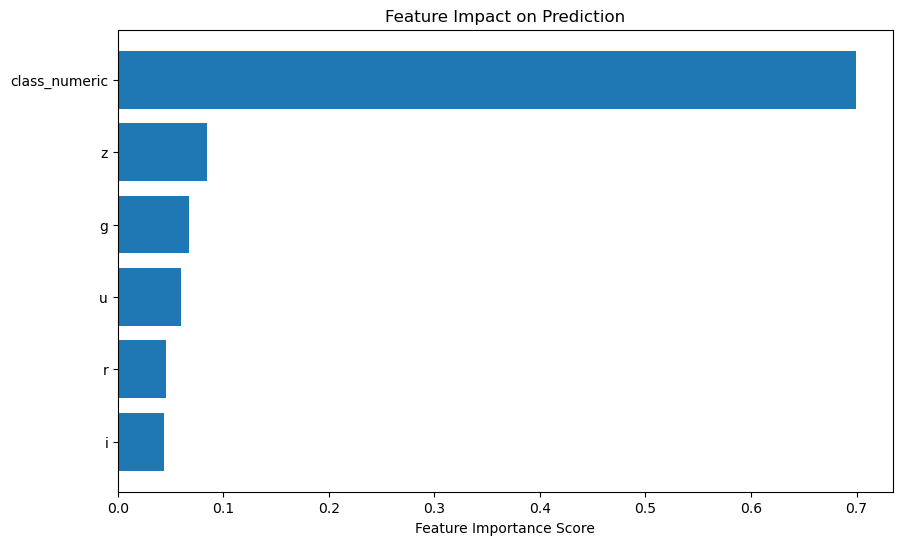

In [12]:
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.barh(range(len(features)), importances[indices], align="center")
plt.yticks(range(len(features)), [features[i] for i in indices])
plt.xlabel("Feature Importance Score")
plt.title("Feature Impact on Prediction")
plt.gca().invert_yaxis()
plt.show()

In [13]:
df['u-g'] = df['u'] - df['g']
df['g-r'] = df['g'] - df['r']
df['r-i'] = df['r'] - df['i']
df['i-z'] = df['i'] - df['z']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 52 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   objid           200000 non-null  int64  
 1   u               200000 non-null  float64
 2   g               200000 non-null  float64
 3   r               200000 non-null  float64
 4   i               200000 non-null  float64
 5   z               200000 non-null  float64
 6   modelMag_u      200000 non-null  float64
 7   modelMag_g      200000 non-null  float64
 8   modelMag_r      200000 non-null  float64
 9   modelMag_i      200000 non-null  float64
 10  modelMag_z      200000 non-null  float64
 11  nMgyPerCount_u  200000 non-null  float64
 12  nMgyPerCount_g  200000 non-null  float64
 13  nMgyPerCount_r  200000 non-null  float64
 14  nMgyPerCount_i  200000 non-null  float64
 15  nMgyPerCount_z  200000 non-null  float64
 16  petroMag_u      200000 non-null  float64
 17  petroMag_g

In [14]:
features2 = ['u', 'g', 'r', 'i', 'z','u-g','g-r','r-i','i-z','nMgyPerCount_u','nMgyPerCount_g','nMgyPerCount_r','nMgyPerCount_i','nMgyPerCount_z',
            'modelMag_u','modelMag_g','modelMag_r','modelMag_i','modelMag_z',
             'petroMag_u','petroMag_g','petroMag_r','petroMag_i','petroMag_z',
             'cModelMag_u','cModelMag_g','cModelMag_r','cModelMag_i','cModelMag_z',
             'fiberMag_u','fiberMag_g','fiberMag_r','fiberMag_i','fiberMag_z',
             'psfMag_u','psfMag_g','psfMag_r','psfMag_i','psfMag_z',
             'err_u','err_g','err_r','err_i','err_z',
             'expAB_r','deVAB_r','expRad_r','deVRad_r']
X2 = df[features2]
y2 = df[target]

In [15]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)
rf = RandomForestRegressor(n_estimators=500, random_state=42,bootstrap=True)
rf.fit(X_train2, y_train2)
y_pred = rf.predict(X_test2)
mse = mean_squared_error(y_test2, y_pred)
r2 = r2_score(y_test2, y_pred)


KeyboardInterrupt: 

In [ ]:
importances = rf.feature_importances_
indices2 = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.barh(range(len(features2)), importances[indices2], align="center")
plt.yticks(range(len(features2)), [features2[i] for i in indices2])
plt.xlabel("Feature Importance Score")
plt.title("Feature Impact on Prediction")
plt.gca().invert_yaxis()
plt.show()

In [ ]:
importances

In [16]:
#R squared of first model
r1 = r2_score(y_test,test_pred)
print("for first model:")
print(f"MSE ={test_loss},R-Squared={r1}")

for first model:
MSE =0.027612271642411316,R-Squared=0.8541519169543714
